In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from datetime import datetime
import warnings

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

start = time.perf_counter()

### Functions for Results

In [2]:
def med(df, col, deci=None):
    median = round(df[col].median(),deci)
    return median

def avg(df, col, deci=None):
    average = round(df[col].mean(), deci)
    return average

def max(df, col, deci=None):
    maximum = round(df[col].max(),deci)
    return maximum

def sum(df, col, deci=None):
    total = round(df[col].sum(),deci)
    return total

def midp(df, col):
    midpoint = (df[col].max() + df[col].min()) / 2
    return midpoint

def rolla(df, col, windw):
    rolling_average = df[col].rolling(window=windw).mean()
    return rolling_average

def rnd(val, deci):
    new = round(val, deci)
    return new

Only counting activities post Europe, export HeartWatch Workouts from Jul 17 - Today and add the csv to the wd

In [3]:
df = pd.read_csv('HeartWatch-Workouts-20230717-to-20230913.csv')

In [4]:
df = df.drop(['Date', 'from', 'to', 'rpe', 'Load', 'bpm-lo', 'bpm-90%+-%', '90%+-mins',
              'bpm-80-90%-%', '80-90%-mins','bpm-70-80%-%', '70-80%-mins','bpm-60-70%-%',
              '60-70%-mins','bpm-50-60%-%', '50-60%-mins'], axis=1)

# Drop Run w/ Bear
df = df.drop(19)

In [5]:
# Fix Datetime Columns
df['ISO'] = pd.to_datetime(df['ISO'])
df['Duration'] = pd.to_timedelta(df['Duration'])
df['/km'] = pd.to_timedelta(df['/km'])
df['Date'] = df['ISO'].dt.date

df.set_index('ISO', inplace=True) 

wklySUM = pd.DataFrame(df[df['Type'] == 'Running'].groupby(pd.Grouper(freq='W-SUN')).agg('sum'))
wklyAVG = pd.DataFrame(df[df['Type'] == 'Running'].groupby(pd.Grouper(freq='W-SUN')).agg('mean'))

# print(wklySUM.head())
# print(wklyAVG.head())

In [6]:
dfRun = df[df['Type'] == 'Running']
dfBike = df[df['Type'] == 'Cycling']
dfWalk = df[df['Type'] == 'Walking']
dfOther = df[~df['Type'].isin(['Running', 'Cycling', 'Walking'])]

# print(dfRun.info())
# print(dfBike.info())
# print(dfWalk.info())
# print(dfOther.head())

In [7]:
# Pace Calculation
# Calculate the total seconds of Duration column
total_seconds = dfRun['Duration'].dt.total_seconds()

# Average Pace from M/S
mps = dfRun['km'].sum()*1000 / total_seconds.sum()
kph = mps * 3.6
mpk = 60 / kph

integer_part = int(mpk)
decimal_part = mpk - integer_part

# Convert decimal part to minutes by dividing by 60
decimal_minutes = round(decimal_part * 60,0)

In [8]:
# Weighted HR
dfRunWght = dfRun

# Convert the time delta to decimal hours and create a new column
dfRunWght["Duration"] = dfRunWght["Duration"].apply(lambda x: x.total_seconds() / 3600)
dfRunWght['Weighted HR'] = dfRunWght['Duration'] * dfRunWght['bpm-Avg.']

# HR/Speed Decimal
dfRun['HR/Speed'] = (dfRun['bpm-Avg.'] / dfRun['km/h']) 

# Cumulative Sum
dfRun['CumKM'] = dfRun['km'].cumsum()

In [9]:
dfRun.tail()

,Duration,Type,bpm-Avg.,bpm-%,bpm-hi,Cals,Cals/h,km,km/h,/km,Date,Weighted HR,HR/Speed,CumKM
ISO,,,,,,,,,,,,,,
2023-09-04 10:36:58-04:00,0.709722,Running,146.0,76.2,164.0,527.6,743.4,6.59,9.3,0 days 00:06:27,2023-09-04,103.619444,15.698925,192.36
2023-09-08 10:27:32-04:00,0.821667,Running,154.4,80.6,169.0,665.9,810.1,8.07,9.8,0 days 00:06:06,2023-09-08,126.865333,15.755102,200.43
2023-09-09 11:15:43-04:00,1.629167,Running,151.2,78.9,213.0,930.9,571.4,11.05,6.8,0 days 00:08:50,2023-09-09,246.330000,22.235294,211.48
2023-09-12 13:22:52-04:00,0.793889,Running,143.7,75.0,156.0,554.3,698.2,6.63,8.3,0 days 00:07:11,2023-09-12,114.081833,17.313253,218.11
2023-09-13 12:38:36-04:00,1.284722,Running,156.3,81.6,190.0,967.2,752.8,12.76,9.9,0 days 00:06:02,2023-09-13,200.802083,15.787879,230.87


## Graphs

### Running Distance Frequency 

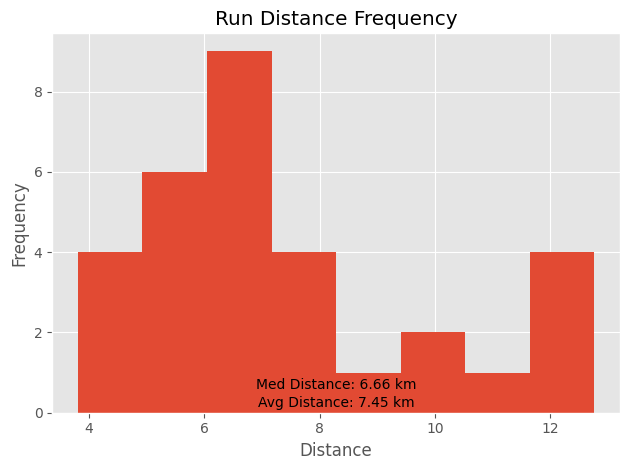

In [20]:
rdf_bins = int(dfRun['km'].max() - dfRun['km'].min())
mid_dist = midp(dfRun, 'km')

# with plt.xkcd():
plt.hist(dfRun['km'], bins=rdf_bins)

# Average/Median Distance Text
avg_d = avg(dfRun, 'km',2)
med_d = med(dfRun, 'km',2)
mid_d = midp(dfRun, 'km')

plt.text(mid_dist, 0.25, f'Avg Distance: {avg_d:.2f} km',
        ha='center', va='center', fontsize=10, color='black')
plt.text(mid_dist, 0.7, f'Med Distance: {med_d:.2f} km',
        ha='center', va='center', fontsize=10, color='black')

plt.title('Run Distance Frequency')
plt.xlabel('Distance')
plt.ylabel('Frequency')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Graphs/Distance Frequency.png', dpi=300)
plt.show()

### Average Heart Rate Frequency

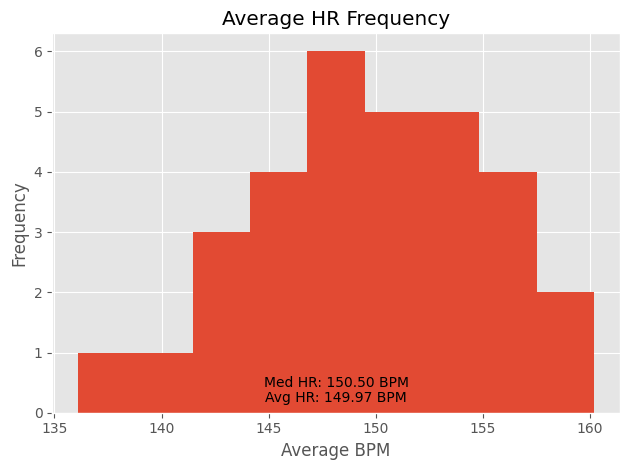

In [11]:
hrf_bins = int((dfRun['bpm-Avg.'].max() - dfRun['bpm-Avg.'].min())/2.5)

plt.hist(dfRun['bpm-Avg.'], bins=hrf_bins)

# Average HR Text
avg_hr = avg(dfRun, 'bpm-Avg.',2)
med_hr = med(dfRun, 'bpm-Avg.',2)
mid_hr = midp(dfRun, 'bpm-Avg.')

plt.text(mid_hr, .25, f'Avg HR: {avg_hr:.2f} BPM',
         ha='center', va='center', fontsize=10, color='black', transform=plt.gca().transData)
plt.text(mid_hr, .5, f'Med HR: {med_hr:.2f} BPM',
         ha='center', va='center', fontsize=10, color='black', transform=plt.gca().transData)

plt.title('Average HR Frequency')
plt.xlabel('Average BPM')
plt.ylabel('Frequency')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Graphs/HR Frequency.png', dpi=300)
plt.show()

### Average Heart Rate versus Average Speed (km/h)

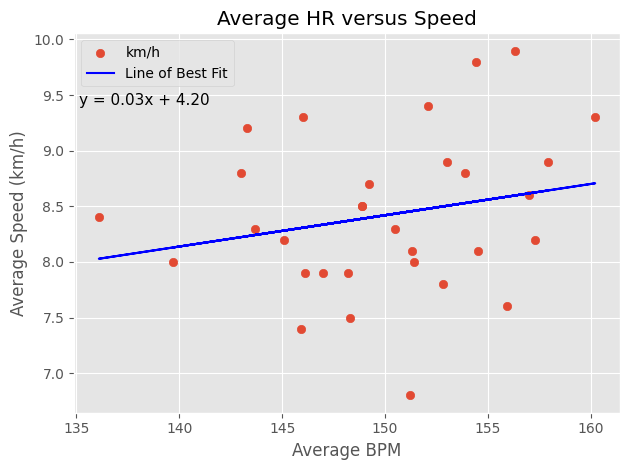

In [12]:
# Line of Best Fit
# Fit a linear regression line to the data
degree = 1
coefficients = np.polyfit(dfRun['bpm-Avg.'], dfRun['km/h'], degree)
slope = coefficients[0]
intercept = coefficients[1]
# Calculate the predicted y-values using the line equation
predicted_y = slope * dfRun['bpm-Avg.'] + intercept
equation = f'y = {slope:.2f}x + {intercept:.2f}'

# Plot
plt.scatter('bpm-Avg.', 'km/h', data=dfRun)
plt.plot(dfRun['bpm-Avg.'], predicted_y, color='blue', label='Line of Best Fit')
plt.xlabel('Average BPM')
plt.ylabel('Average Speed (km/h)')
plt.title('Average HR versus Speed')
plt.text(0.01, 0.81, equation, fontsize=11, transform=plt.gca().transAxes)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Graphs/SpeedvsHR.png', dpi=300)
plt.show()

### Heart Rate / Speed over Time

Lower is better

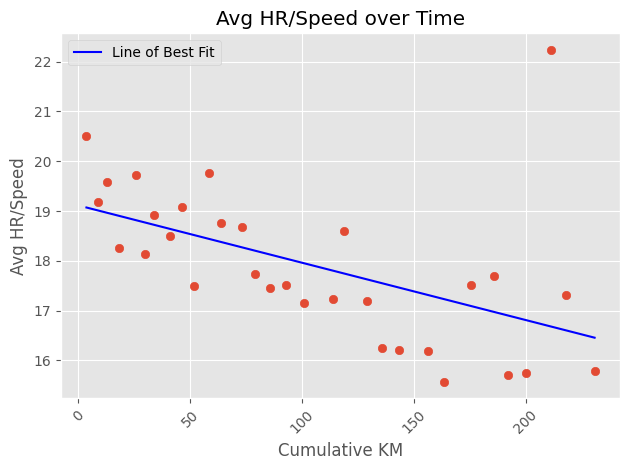

In [13]:
degree1 = 1
coefficients1 = np.polyfit(dfRun['CumKM'], dfRun['HR/Speed'], degree)
slope1 = coefficients1[0]
intercept1 = coefficients1[1]
# Calculate the predicted y-values using the line equation
predicted_y1 = slope1 * dfRun['CumKM'] + intercept1
equation1 = f'y = {slope1:.2f}x + {intercept1:.1f}'

plt.scatter(dfRun['CumKM'], y= dfRun['HR/Speed'])
plt.plot(dfRun['CumKM'], predicted_y1, color='blue', label='Line of Best Fit')
# plt.text(0.75, 0.86, equation1, fontsize=10, transform=plt.gca().transAxes)
plt.xlabel('Cumulative KM')
plt.xticks(rotation=45)
plt.ylabel('Avg HR/Speed')
plt.title('Avg HR/Speed over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Graphs/HR-Speed over Time.png', dpi=300)
plt.show()

### Weekly Distance


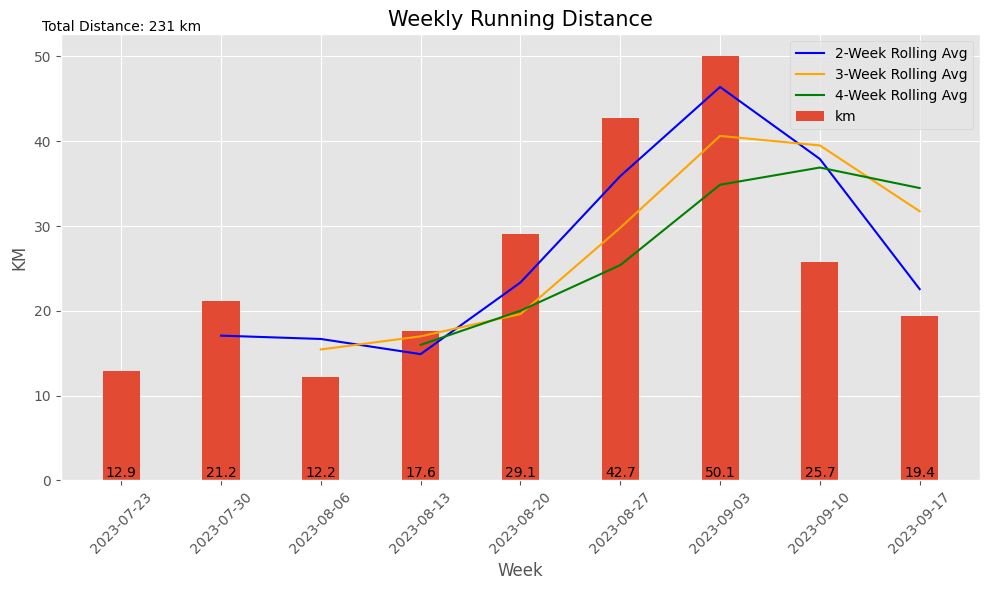

In [14]:
plt.figure(figsize=(10,6))

# Rolling Average 
rolling_average2 = rolla(wklySUM, 'km', 2)
plt.plot(wklySUM.index, rolling_average2, label='2-Week Rolling Avg', color='blue')
rolling_average3 = rolla(wklySUM, 'km', 3)
plt.plot(wklySUM.index, rolling_average3, label='3-Week Rolling Avg', color='orange')
rolling_average4 = rolla(wklySUM, 'km', 4)
plt.plot(wklySUM.index, rolling_average4, label='4-Week Rolling Avg', color='green')

# Toal Distance Text
total_distance = sum(wklySUM, 'km')
plt.text(wklySUM.index[0], wklySUM['km'].max() + 2.5, f'Total Distance: {total_distance:.0f} km',
        ha='center', va='bottom', fontsize=10, color='black', transform=plt.gca().transData)

plt.bar(wklySUM.index, wklySUM['km'], label='km', width=2.6)
for idx, value in enumerate(wklySUM['km']):
        plt.text(wklySUM.index[idx], 0, f'{value:.1f}', ha='center', va='bottom',
        fontsize=10, color='black')

plt.xlabel('Week')
plt.ylabel('KM')
plt.title('Weekly Running Distance', fontsize=15)
plt.legend()
plt.xticks(wklySUM.index, wklySUM.index.strftime('%Y-%m-%d'), rotation=45)
plt.tight_layout()
plt.savefig('Graphs/Weekly Distance.png', dpi=300)
plt.show()

### Cumulative Distance

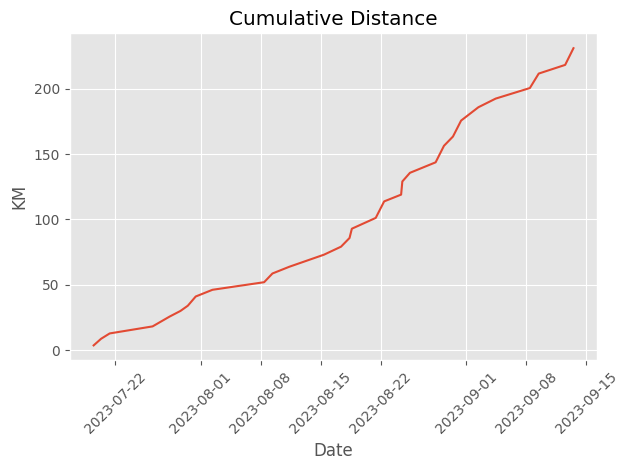

In [15]:
plt.plot(dfRun.index, dfRun['CumKM'])
plt.title('Cumulative Distance')
plt.xlabel('Date')
plt.ylabel('KM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Graphs/Cumulative Distance.png', dpi=300)
plt.show()

### Running Boxplots

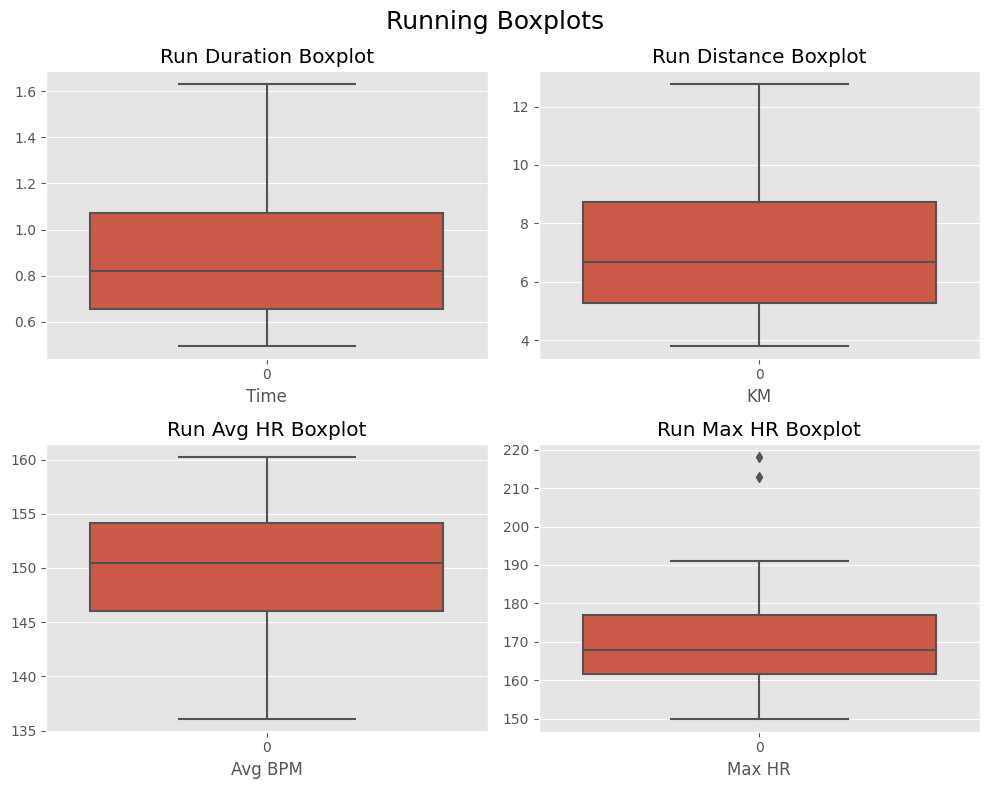

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# Run Duration Boxplot
sns.boxplot(dfRun['Duration'], ax=axes[0, 0])
axes[0, 0].set_title('Run Duration Boxplot')
axes[0, 0].set_xlabel('Time')

# Run Distance Boxplot
sns.boxplot(dfRun['km'], ax=axes[0, 1])
axes[0, 1].set_title('Run Distance Boxplot')
axes[0, 1].set_xlabel('KM')

# Run Average HR Boxplot
sns.boxplot(dfRun['bpm-Avg.'], ax=axes[1, 0])
axes[1, 0].set_title('Run Avg HR Boxplot')
axes[1, 0].set_xlabel('Avg BPM')

# Run Max HR Boxplot
sns.boxplot(dfRun['bpm-hi'], ax=axes[1, 1])
axes[1, 1].set_title('Run Max HR Boxplot')
axes[1, 1].set_xlabel('Max HR')

fig.suptitle('Running Boxplots', fontsize=18)

plt.tight_layout()
plt.savefig('Graphs/Run Boxplots.png', dpi=300)
plt.show()

In [17]:
# Duration
avg_wght_hr = round(dfRunWght['Weighted HR'].sum() / dfRunWght['Duration'].sum(),2)
avg_dur = dfRun['Duration'].mean()
tot_dur = dfRun['Duration'].sum()
max_dur = dfRun['Duration'].max()

# Count Runs
num_runs = dfRun['km'].count()
num_rides = dfBike['km'].count()
num_walks = dfWalk['km'].count()
new_run = dfRun['Date'][-1]
new_ride = dfBike['Date'][-1]
new_walk = dfWalk['Date'][-1]

avghr_u155 = dfRun[dfRun['bpm-Avg.'] < 155].count()['bpm-Avg.']
pavghr_u155 = round(avghr_u155 / num_runs *100,2)
avghr_u150 = dfRun[dfRun['bpm-Avg.'] < 150].count()['bpm-Avg.']
pavghr_u150 = round(avghr_u150 / num_runs *100,2)

ovr_5k = dfRun[dfRun['km'] >=5].count()['km']
povr_5k = round(ovr_5k / num_runs *100,2)
ovr_10k = dfRun[dfRun['km'] >=10].count()['km']
povr_10k = round(ovr_10k / num_runs *100,2)
runs_per_day = round(num_runs / dfRun['Date'].nunique(),3)
date_cts = dfRun['Date'].value_counts()
dbl_days = date_cts[date_cts > 1].count()

# Durations to Time Format
avg_dur_h = int(avg_dur)
max_dur_h = int(max_dur)
tot_dur_h = int(tot_dur)

avg_dur_m_dec = (avg_dur - avg_dur_h)*60
max_dur_m_dec = (max_dur - max_dur_h)*60
tot_dur_m_dec = (tot_dur - tot_dur_h)*60

avg_dur_m = int(avg_dur_m_dec)
max_dur_m = int(max_dur_m_dec)
tot_dur_m = int(tot_dur_m_dec)

avg_dur_s = int((avg_dur_m_dec - avg_dur_m)*60)
max_dur_s = int((max_dur_m_dec - max_dur_m)*60)
tot_dur_s = int((tot_dur_m_dec - tot_dur_m)*60)

avg_dur_f = str(avg_dur_h) + ':' + str(avg_dur_m) + ':' + str(avg_dur_s)
max_dur_f = str(max_dur_h) + ':' + str(max_dur_m) + ':' + str(max_dur_s)
tot_dur_f = str(tot_dur_h) + ':' + str(tot_dur_m) + ':' + str(tot_dur_s)

## Running Stats

In [18]:
print(f'Most Recent Run: {new_run}')
print('----------------------------')
print(f'Runs: {num_runs}')
print(f'Runs > 5k(%): {ovr_5k} ({povr_5k}%)')
print(f'Runs > 10k(%): {ovr_10k} ({povr_10k}%)')
print(f'Runs < 155bpm(%): {avghr_u155} ({pavghr_u155}%)')
print(f'Runs < 150bpm(%): {avghr_u150} ({pavghr_u150}%)')
print(f'Double Days: {dbl_days}')
print(f'Runs per Day: {runs_per_day}')

print('----------------------------')
print(f'Average Duration: {avg_dur_f}')
print(f'Average Distance: {avg(dfRun, "km",2)}')
print(f"Average Pace: {integer_part}:{decimal_minutes}")
print(f'Average Speed: {avg(dfRun, "km/h",2)}')
print(f'Average Weighted HR: {avg_wght_hr}')
print(f'Average HR: {avg(dfRun, "bpm-Avg.",2)}')
print(f'Average Max HR: {avg(dfRun, "bpm-hi",2)}')
print(f'Average Calories: {avg(dfRun, "Cals",)}')

print('----------------------------')
print(f'Median Distance: {med(dfRun, "km", 2)}')
print(f'Median Avg HR: {med(dfRun, "bpm-Avg.", 2)}')
print(f'Median Max HR: {med(dfRun, "bpm-hi", 2)}')
print(f'Median Calories: {med(dfRun, "Cals",)}')

print('----------------------------')
print(f'Max Duration: {max_dur_f}')
print(f'Max Distance: {max(dfRun, "km",2)}')
print(f'Max Average HR: {max(dfRun, "bpm-Avg.",2)}')
print(f'Max Max HR: {max(dfRun, "bpm-hi", 2)}')
print(f'Max Calories: {max(dfRun, "Cals",)}')

print('----------------------------')
print(f'Total Duration: {tot_dur_f}')
print(f'Total Distance: {sum(dfRun, "km", 2)}')
print(f'Total Running Calories: {sum(dfRun, "Cals",)}')

Most Recent Run: 2023-09-13
----------------------------
Runs: 31
Runs > 5k(%): 27 (87.1%)
Runs > 10k(%): 7 (22.58%)
Runs < 155bpm(%): 25 (80.65%)
Runs < 150bpm(%): 15 (48.39%)
Double Days: 2
Runs per Day: 1.069
----------------------------
Average Duration: 0:52:54
Average Distance: 7.45
Average Pace: 7:6.0
Average Speed: 8.42
Average Weighted HR: 149.95
Average HR: 149.97
Average Max HR: 171.32
Average Calories: 610
----------------------------
Median Distance: 6.66
Median Avg HR: 150.5
Median Max HR: 168.0
Median Calories: 558
----------------------------
Max Duration: 1:37:45
Max Distance: 12.76
Max Average HR: 160.2
Max Max HR: 218.0
Max Calories: 1032
----------------------------
Total Duration: 27:20:10
Total Distance: 230.87
Total Running Calories: 18898


## Riding/Walking Stats

In [19]:
print(f'Most Recent Ride: {new_ride}')
print(f'Rides: {num_rides}')
print(f'Average Distance: {avg(dfBike, "km", 2)}')
print(f'Average HR: {avg(dfBike, "bpm-Avg.", 2)}')
print(f'Average Max HR: {avg(dfBike, "bpm-hi", 2)}')
print(f'Average Calories: {avg(dfBike, "Cals",)}')
print(f'Average Speed: {avg(dfBike, "km/h", 2)}')
print(f'Median Distance: {med(dfBike, "km", 2)}')
print(f'Median Avg HR: {med(dfBike, "bpm-Avg.", 2)}')
print(f'Median Max HR: {med(dfBike, "bpm-hi", 2)}')
print(f'Median Calories: {med(dfBike, "Cals",)}')
print(f'Median Speed: {med(dfBike, "km/h", 2)}')
print('----------------------------')
print(f'Most Recent Walk: {new_walk}')
print(f'Walks: {num_walks}')
print(f'Average Distance: {avg(dfWalk, "km", 2)}')
print(f'Average HR: {avg(dfWalk, "bpm-Avg.", 2)}')
print(f'Average Max HR: {avg(dfWalk, "bpm-hi", 2)}')
print(f'Average Calories: {avg(dfWalk, "Cals",)}')
print(f'Median Distance: {med(dfWalk, "km", 2)}')
print(f'Median Avg HR: {med(dfWalk, "bpm-Avg.", 2)}')
print(f'Median Max HR: {med(dfWalk, "bpm-hi", 2)}')
print(f'Median Calories: {med(dfWalk, "Cals",)}')
print('----------------------------')
print('Maximums')
print(f'Max Bike Distance: {max(dfBike, "km", 2)}')
print(f'Max Bike Calories: {max(dfBike, "Cals",)}')
print(f'Max Walk Distance: {max(dfWalk, "km", 2)}')
print(f'Max Walk Calories: {max(dfWalk, "Cals",)}')
print('----------------------------')
print("Totals")
print(f'Total Bike Distance: {sum(dfBike, "km", 2)}')
print(f'Total Bike Calories: {sum(dfBike, "Cals",)}')
print(f'Total Walk Distance: {sum(dfWalk, "km", 2)}')
print(f'Total Walk Calories: {sum(dfWalk, "Cals",)}')
print('----------------------------')
print(f'Runtime: {round(time.perf_counter() - start,2)}s')


Most Recent Ride: 2023-08-16
Rides: 5
Average Distance: 28.76
Average HR: 140.42
Average Max HR: 179.0
Average Calories: 612
Average Speed: 17.82
Median Distance: 31.5
Median Avg HR: 140.9
Median Max HR: 182.0
Median Calories: 661
Median Speed: 19.0
----------------------------
Most Recent Walk: 2023-08-30
Walks: 9
Average Distance: 3.98
Average HR: 111.94
Average Max HR: 129.0
Average Calories: 231
Median Distance: 3.83
Median Avg HR: 113.3
Median Max HR: 127.0
Median Calories: 208
----------------------------
Maximums
Max Bike Distance: 35.16
Max Bike Calories: 829
Max Walk Distance: 6.42
Max Walk Calories: 406
----------------------------
Totals
Total Bike Distance: 143.8
Total Bike Calories: 3061
Total Walk Distance: 35.85
Total Walk Calories: 2079
----------------------------
Runtime: 2.64s
